In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Concatenate,UpSampling2D,Input,AveragePooling2D,SpatialDropout2D
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy,Precision , Recall
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def deeplabv3(input_size):
    input_scan = Input(input_size)
    conv1 = Conv2D(32,(3,3),padding="same",activation="relu")(input_scan)
    conv1 = Conv2D(32,(3,3),padding="same",activation="relu")(conv1)
    pool1 = MaxPooling2D((2,2),strides=2)(conv1)
    conv2 = Conv2D(64,(3,3),padding="same",activation="relu")(pool1)
    conv2 = Conv2D(64,(3,3),padding="same",activation="relu")(conv2)
    pool2 = MaxPooling2D((2,2),strides=2)(conv2)
    conv3 = Conv2D(128,(3,3),padding="same",activation="relu")(pool2)
    conv3 = Conv2D(128,(3,3),padding="same",activation="relu")(conv3)
    pool3 = MaxPooling2D((2,2),strides=2)(conv3)
    conv4 = Conv2D(256,(3,3),padding="same",activation="relu")(pool3)
    conv4 = Conv2D(256,(3,3),padding="same",activation="relu")(conv4)
    pool4 = MaxPooling2D((2,2),strides=2)(conv4)
    conv5 = Conv2D(512,(3,3),padding="same",activation="relu")(pool4)

    #atrousconv
    y_pool = AveragePooling2D((conv5.shape[1], conv5.shape[2]))(conv5)
    y_pool = Conv2D(256, 1, padding='same',activation="relu")(y_pool)
    y_pool = UpSampling2D((conv5.shape[1], conv5.shape[2]))(y_pool)
    y_1 = Conv2D(256, 1, dilation_rate=1, padding='same', activation="relu")(conv5)
    y_2 = Conv2D(256, 3, dilation_rate=6, padding='same', activation="relu")(conv5)
    y_3 = Conv2D(256, 3, dilation_rate=12, padding='same', activation="relu")(conv5)
    y_4 = Conv2D(256, 3, dilation_rate=18, padding='same', activation="relu")(conv5)
    y = Concatenate()([y_pool,  y_1, y_2, y_3,y_4])
    y = Conv2D(256,1,  padding='same',activation="relu")(y)
    x_a = UpSampling2D((4, 4))(y)
    x_b = Conv2D(48,1,  padding='same',activation="relu")(conv3)
    out = Concatenate()([x_a,x_b])
    out = Conv2D(256,3,  padding='same',activation="relu")(out)
    out = Conv2D(256,3,  padding='same',activation="relu")(out)
    out = UpSampling2D((2, 2))(out)
    out = Concatenate()([out,conv2])
    out =  out = Conv2D(256,3,  padding='same',activation="relu")(out)
    out = UpSampling2D((2, 2))(out)
    out_layer = Conv2D(1,1,  padding='same',activation="sigmoid")(out)
    model = tf.keras.Model(input_scan,out_layer,name='deeplabv3')
    return model

In [3]:
model = deeplabv3((512,512,1))

In [4]:
model.summary()

Model: "deeplabv3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                         

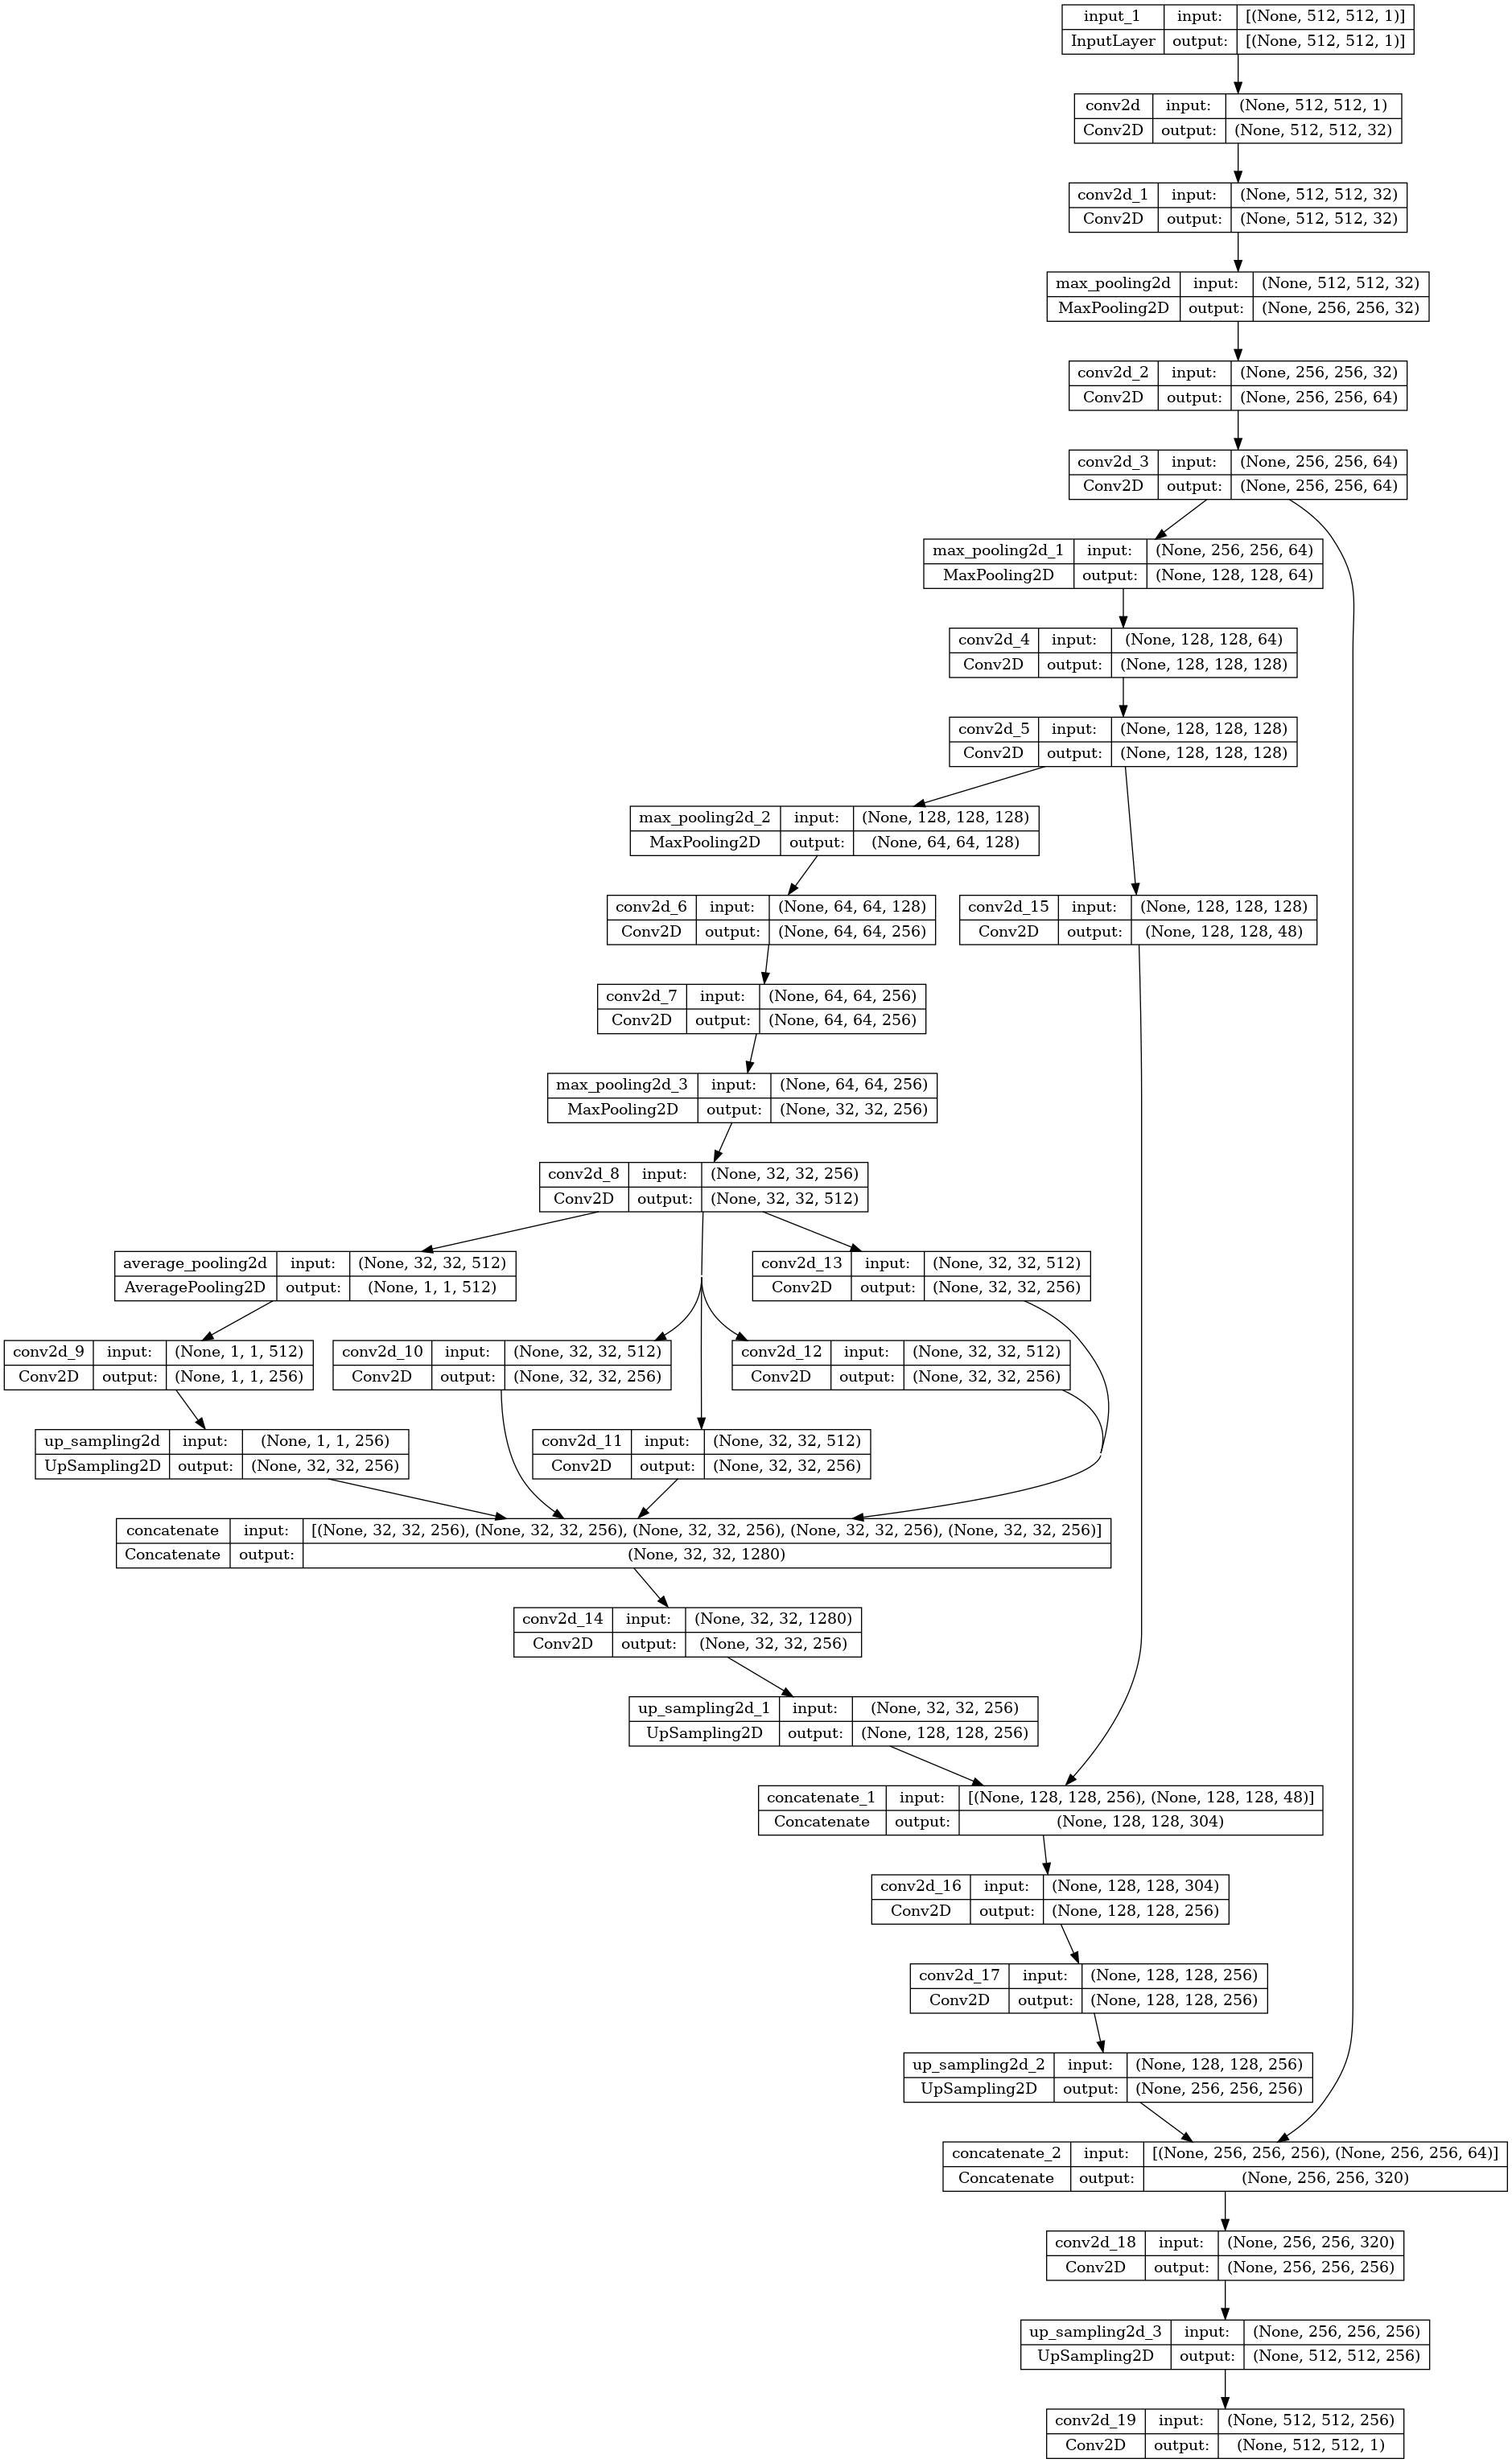

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, rankdir='TB',
to_file='model_cifar10.png')

In [6]:
X1 = np.load("/kaggle/input/data12/X1.npy")
X0 = np.load("/kaggle/input/data12/X0.npy")
Y1 = np.load("/kaggle/input/data12/mask1.npy")
Y0 = np.load("/kaggle/input/data12/mask0.npy")

In [7]:
X1.shape

(1153, 512, 512, 1)

In [8]:
X = np.concatenate((X1,X0),axis=0)
Y = np.concatenate((Y1,Y0),axis=0)

In [9]:
X1=0
X0=0
Y1 =0

In [10]:
X = X/255
Y = Y/255

In [11]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size =0.20,random_state=48)

In [12]:

Y0=0
X=0
Y=0


In [13]:
from tensorflow.keras.layers import Flatten
def iou_score(y_true, y_pred):
    intersection = 0 
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection =  (2.*(y_true_f * y_pred_f) + tf.keras.backend.epsilon())
    union = (y_true_f + y_pred_f + tf.keras.backend.epsilon())
    return (intersection/union)

In [14]:
model.compile(optimizer = Adam(learning_rate=0.0001),loss = "BinaryCrossentropy",metrics=[iou_score])

In [15]:
hist = model.fit(Xtrain,Ytrain,epochs=50,batch_size=8,validation_data=(Xtest,Ytest))

Epoch 1/50
144/144 [==============================] - 89s 487ms/step - loss: 0.0434 - iou_score: 0.2089 - val_loss: 0.0038 - val_iou_score: 0.1342
Epoch 2/50
144/144 [==============================] - 74s 513ms/step - loss: 0.0035 - iou_score: 0.1603 - val_loss: 0.0035 - val_iou_score: 0.2465
Epoch 3/50
144/144 [==============================] - 74s 513ms/step - loss: 0.0031 - iou_score: 0.2470 - val_loss: 0.0030 - val_iou_score: 0.2704
Epoch 4/50
144/144 [==============================] - 69s 481ms/step - loss: 0.0023 - iou_score: 0.3584 - val_loss: 0.0021 - val_iou_score: 0.4610
Epoch 6/50
144/144 [==============================] - 74s 513ms/step - loss: 0.0021 - iou_score: 0.4204 - val_loss: 0.0020 - val_iou_score: 0.4612
Epoch 7/50
144/144 [==============================] - 69s 481ms/step - loss: 0.0018 - iou_score: 0.4839 - val_loss: 0.0016 - val_iou_score: 0.5487
Epoch 8/50
144/144 [==============================] - 69s 481ms/step - loss: 0.0016 - iou_score: 0.5332 - val_loss: 0.

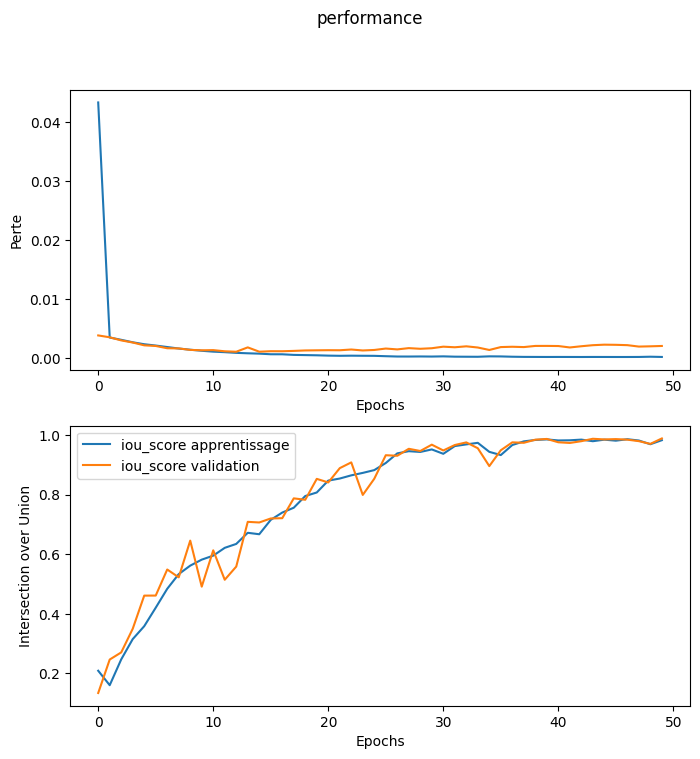

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.suptitle("performance") 
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, 50), hist.history["loss"], label="Perte apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_loss"], label="Perte validation")
plt.xlabel("Epochs")
plt.ylabel("Perte") 
plt.subplot(2, 1, 2)
plt.plot(np.arange(0, 50), hist.history["iou_score"], label="iou_score apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_iou_score"], label="iou_score validation") 
plt.xlabel("Epochs") 
plt.ylabel("Intersection over Union")


plt.legend()


In [22]:
model.evaluate(Xtest,Ytest,batch_size=8)

36/36 [==============================] - 6s 159ms/step - loss: 0.0021 - iou_score: 0.9864


[0.0020905963610857725, 0.9864326119422913]

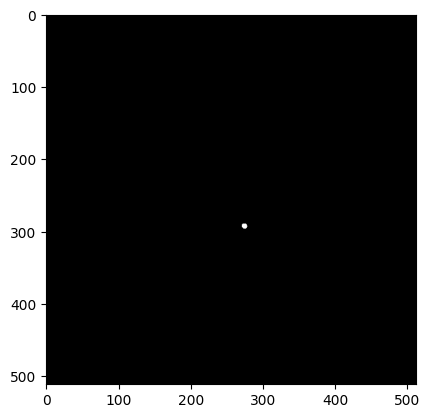

In [25]:
plt.imshow(Ytest[8],cmap="gray")

In [26]:

y_1 = model.predict(Xtest[8].reshape((1,512,512, 1)))

1/1 [==============================] - 1s 1s/step


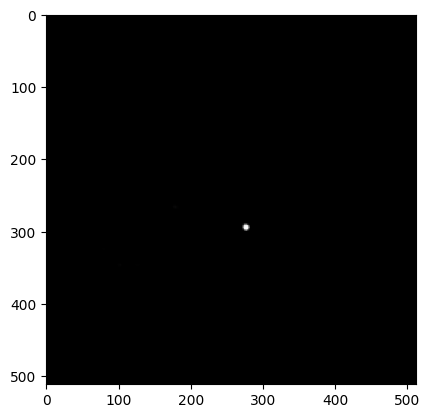

In [27]:

y_1 = y_1.reshape((512,512))
plt.imshow(y_1,cmap="gray")

In [28]:
y_1.max()

0.9921652

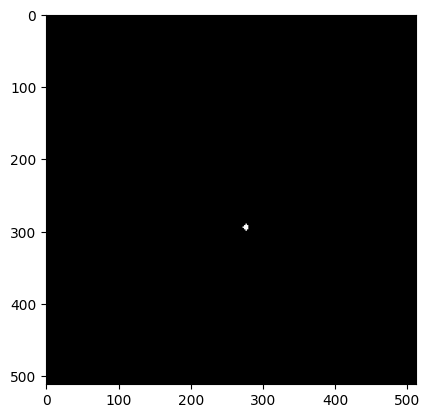

In [29]:
y_1 = np.where(y_1>0.5,1,0)
plt.imshow(y_1,cmap="gray")

In [30]:
y_1.max()

1

In [35]:

norm_img = Xtest[8].reshape((512,512))
img = norm_img * 255

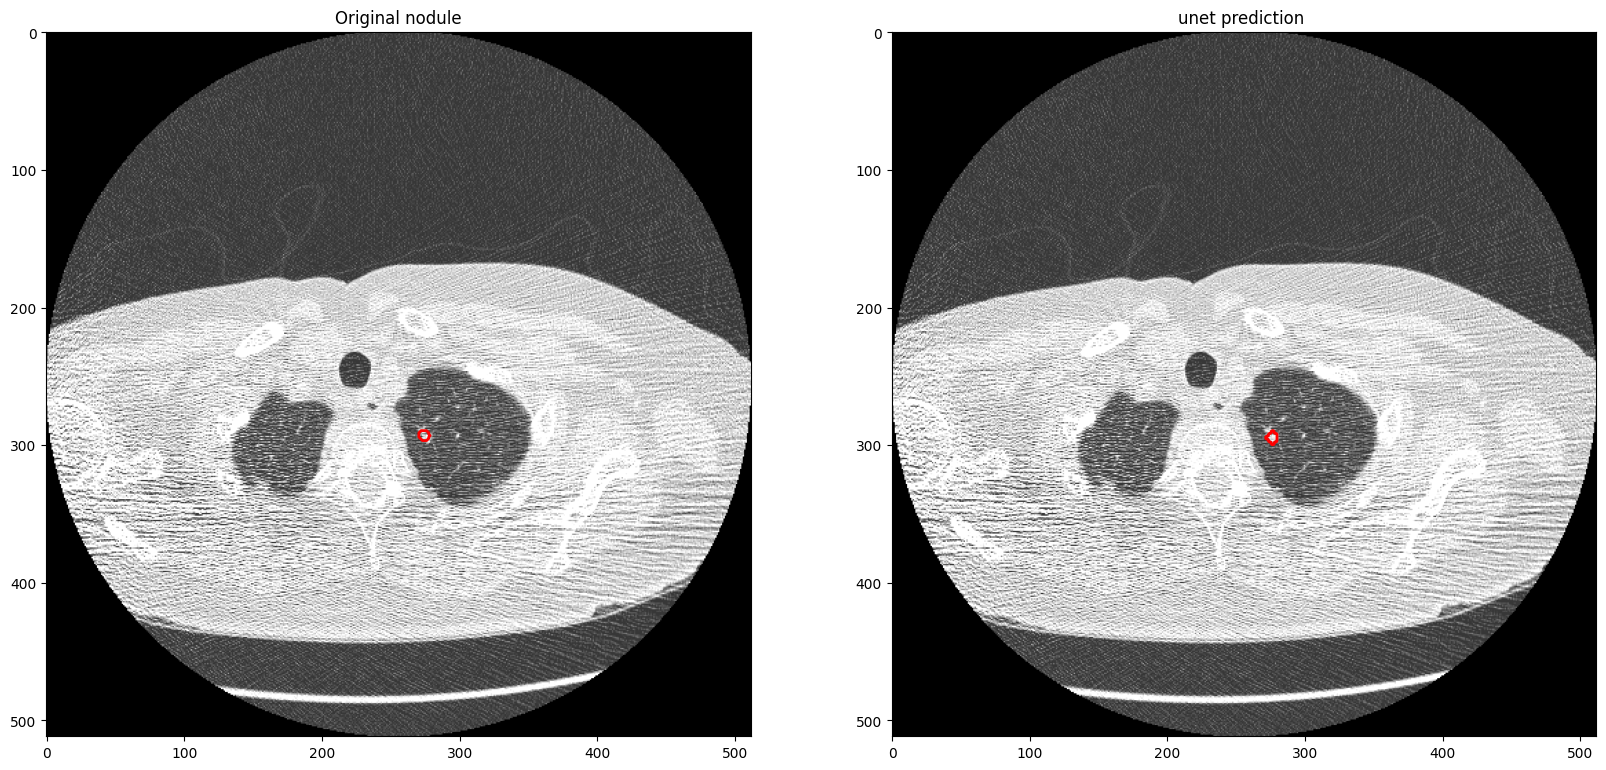

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(img,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(img,cmap='gray')
ax2.set_title('unet prediction ')
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
ax1.contour(Ytest[8].reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
plt.show()

In [37]:
model.save("deeplabv3plus.h5")